# Pose evaluation

In [1]:
%load_ext autoreload
%autoreload 2

import json
from collections import defaultdict
from pathlib import Path

import torch

cameras = defaultdict(dict)
folders = defaultdict(dict)
# cameras["folder"]["method"] = cam2world

In [29]:
# load all the cameras
num_patches = 16  # 4, 16, 64
folder = Path("/home/ethanjohnweber/mounts/mvinpaint-outputs/comparison")
for subfolder in folder.iterdir():
    succeed = True
    for method in ["gt", "mvinpaint", "dust3r"]:
        try:
            path = Path(str(sorted(list((subfolder / method / f"num-patches-{num_patches}").iterdir()))[-1]))
            folders[subfolder.name][method] = path
            with open(path / "nerfstudio" / "transforms.json", "r") as f:
                data = json.load(f)
                cam2world = torch.tensor([data["frames"][i]["transform_matrix"] for i in range(num_patches)])
            cameras[subfolder.name][method] = cam2world
        except:
            succeed = False
    if not succeed and subfolder.name in folders:
        del folders[subfolder.name]
    if not succeed and subfolder.name in cameras:
        del cameras[subfolder.name]

In [30]:
import numpy as np


def compute_angular_error_batch(rotation1, rotation2):
    # https://github.com/jasonyzhang/RayDiffusion/blob/main/ray_diffusion/eval/utils.py#L50
    R_rel = np.einsum("Bij,Bjk ->Bik", rotation2, rotation1.transpose(0, 2, 1))
    t = (np.trace(R_rel, axis1=1, axis2=2) - 1) / 2
    theta = np.arccos(np.clip(t, -1, 1))
    return theta * 180 / np.pi

In [31]:
metrics = defaultdict(dict)
for name in cameras:
    cameras_gt = cameras[name]["gt"]
    R_gt = cameras_gt[:, :3, :3]
    for method in ["gt", "mvinpaint", "dust3r"]:
        cameras_pr = cameras[name][method]
        R_pr = cameras_pr[:, :3, :3]
        angle = compute_angular_error_batch(R_gt.numpy(), R_pr.numpy())
        metrics[name][method] = angle

In [32]:
thresholds = np.arange(15, 91, 5)
print(f"thresholds: {thresholds}")
rra_dict = defaultdict(dict)
for name in cameras:
    for method in ["gt", "mvinpaint", "dust3r"]:
        # if method == "dust3r":
        #     print(metrics[name]["mvinpaint"].mean())
        for thr in thresholds:
            rra = (metrics[name][method] < thr).mean()
            value = rra * (1 / len(metrics))
            try:
                rra_dict[method][thr] += value
            except:
                rra_dict[method][thr] = value

thresholds: [15 20 25 30 35 40 45 50 55 60 65 70 75 80 85 90]


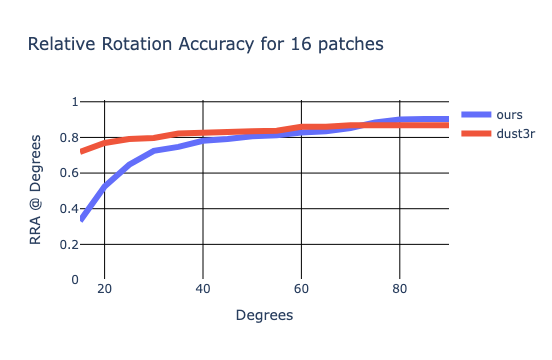

In [36]:
import plotly.graph_objects as go

fig = go.Figure()
for method in ["mvinpaint", "dust3r"]:
    x = sorted(rra_dict[method].keys())
    y = [rra_dict[method][key] for key in x]
    fig.add_trace(go.Scatter(x=x, y=y, mode="lines", name=method.replace("mvinpaint", "ours"), line=dict(width=6)))
# Update layout
fig.update_layout(
    title=f"Relative Rotation Accuracy for {num_patches} patches",
    xaxis_title="Degrees",
    yaxis_title="RRA @ Degrees",
    paper_bgcolor="white",
    plot_bgcolor="white",
    xaxis=dict(showgrid=True, gridwidth=1, gridcolor="black"),
    yaxis=dict(
        showgrid=True,
        gridwidth=1,
        gridcolor="black",
        # Set y-axis range to start and end at 0
        range=[0, 1.01],  # 1.1 is used to add some padding
    ),
)
fig.show()

### Show videos

In [25]:
import mediapy

videos = []
seconds = 3
num_frames = 32
for i, name in enumerate(folders):
    if i < 19:
        continue
    videos = []
    for method in ["gt", "mvinpaint", "dust3r"]:
        image = mediapy.read_image(Path(folders[name][method]) / "images.png")
        image_grid = np.concatenate([image[:, : 8 * 512], image[:, 8 * 512 :]], axis=0)
        image_grid = mediapy.resize_image(image_grid, (512 // 4, 2048 // 4))
        image_grid = np.stack([image_grid for _ in range(num_frames)])
        path = Path(folders[name][method]) / "sample.mp4"
        video = np.array(mediapy.read_video(path))
        video = np.concatenate([image_grid, video], axis=1)
        num_frames = len(video)
        videos.append(video)
        print("here")
    cat_video = np.concatenate(videos, axis=2)
    filename = f"/home/ethanjohnweber/assets/uncalibrated-nvs/{i:06d}.mp4"
    mediapy.write_video(filename, cat_video, fps=num_frames / seconds)
    break

here
here
here


In [26]:
# mediapy.show_videos(videos, fps=num_frames/seconds)

In [27]:
mediapy.show_video(cat_video, fps=num_frames / seconds)